# Importing libraries

In [1]:
# importing matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# add a path to the mypystan.
import sys
sys.path.append('./')
import mypystan

/home/keisukefujii/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import numpy as np

# Generating synthetic data

In [183]:
# position
x = np.arange(0, 1, 0.01)
# latent function
t = np.sin(2.0*np.pi*x) + 0.5 * np.sin(10.0*np.pi*x)
# observed function
y = t + np.random.randn(len(x))*0.3

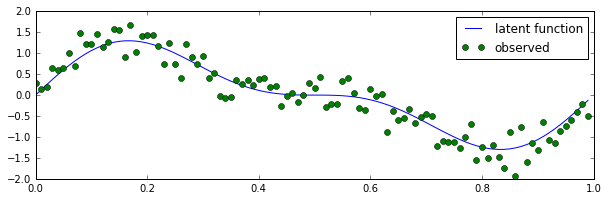

In [184]:
plt.figure(figsize=(10,3))
plt.plot(x, t, label='latent function')
plt.plot(x, y, 'o', label='observed')
plt.legend()

# Analyzing by Stan

## Defining Stan code

In [20]:
stan_code = """
data{
 int<lower=1> n;
 vector[n] x;
 vector[n] y;
}

parameters{
 real<lower=0> alpha;
 real<lower=0> delta;
 real<lower=0> dx;
}

model{
 matrix[n,n] cov;
 vector[n] mu;
 
 for(i in 1:n){
  for(j in 1:i-1){
   cov[i,j] <- alpha*exp(-(x[i]-x[j])*(x[i]-x[j])/(2.0*dx*dx));
   cov[j,i] <- cov[i,j];
  }
  cov[i,i] <- alpha + delta;
  mu[i] <- 0.0;
 }
 
 y ~ multi_normal(mu, cov);
}

generated quantities{
 vector[n] t; // prediction of y at the same x
 
 // this block is just introduced not to output these defined quantities
 {
  matrix[n,n] cov_yy;
  matrix[n,n] cov_yt;
  matrix[n,n] cov_tt;
  matrix[n,n] inv_cov_yy;
  
  for(i in 1:n){
   for(j in 1:i-1){
    cov_yy[i,j] <- alpha*exp(-(x[i]-x[j])*(x[i]-x[j])/(2.0*dx*dx));
    cov_yy[j,i] <- cov_yy[i,j];
    cov_yt[i,j] <- cov_yy[i,j];
    cov_yt[j,i] <- cov_yy[i,j];
    cov_tt[i,j] <- cov_yy[i,j];
    cov_tt[j,i] <- cov_yy[i,j];
   }
   cov_yy[i,i] <- alpha + delta;
   cov_yt[i,i] <- alpha;
   cov_tt[i,i] <- alpha;
  }
  
  inv_cov_yy <- inverse(cov_yy);
  t <- multi_normal_rng(cov_yt * inv_cov_yy * y, cov_tt - cov_yt * inv_cov_yy * cov_yy);
 }
 
}
"""

## Compiling the Stan code

### cmdstan_home の設定

cmdstan を展開したフォルダの情報が必要です。

In [21]:
cmdstan_home = '/home/keisukefujii/stan/cmdstan-2.9.0/'

### Stan_model のコンパイル

pystan.StanModel

http://pystan.readthedocs.org/en/latest/api.html#pystan.StanModel

と使い方はほぼ同じですが、cmdstan_home を引数に渡す必要があります。

In [93]:
stan_model = mypystan.StanModel(model_code=stan_code, model_name='stan_model', cmdstan_home=cmdstan_home)

## StanModel.sampling

pystan.StanModel.sampling

http://pystan.readthedocs.org/en/latest/api.html#pystan.StanModel.sampling

と使い方はほぼ同じですが、インタラクティブに実行するには

wait_during_sampling = True

を指定する必要があります。


また、デフォルトでは毎回output.csv に出力します。

上書きを避けるためには、output_file を指定してください。

In [27]:
rslt = stan_model.sampling(data={'n':len(x), 'x':x, 't':t}, wait_during_sampling=True, chains=1, output_file='stan_out_sampling')

./stan_model id=1 sample num_samples=1000 num_warmup=1000 algorithm=hmc engine=nuts data file=.input.data.R output file=stan_out_sampling1.csv



## StanModel.optimizing

pystan.StanModel.optimizing

http://pystan.readthedocs.org/en/latest/api.html#pystan.StanModel.optimizing

と同様の使い方です。

sampling と同じように、デフォルトでは毎回output.csv に出力します。上書きを避けるためには、output_file を指定してください。

In [155]:
rslt_optimizing = stan_model.optimizing(data={'n':len(x), 'x':x, 'y':y}, output_file='stan_out_optimizing')

### Drawing graph

In [162]:
rslt = mypystan.StanFit4model(['stan_out_optimizing.csv']).extract()

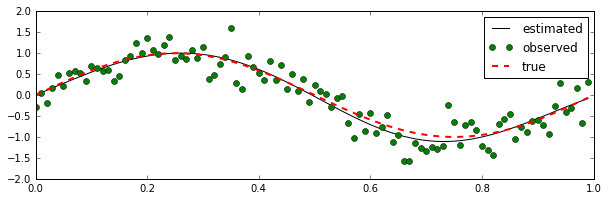

In [182]:
plt.figure(figsize=(10,3))
plt.plot(x, rslt['t'][0], 'k', label='estimated')
plt.plot(x, y, 'go', label='observed')
plt.plot(x, t, '--r', label='true', linewidth=2)
plt.legend()

In [176]:
print 'alpha:', rslt['alpha'][0], ' delta:', rslt['delta'][0], ', dx:', rslt['delta'][0]

alpha: 0.774502  delta: 0.0934682 , dx: 0.0934682


## StanModel.variational

variational が使えます。詳しくは、Stanのマニュアルを参照。

sampling と同じように、デフォルトでは毎回output.csv に出力します。上書きを避けるためには、output_file を指定してください。

In [177]:
rslt_variational = stan_model.variational(data={'n':len(x), 'x':x, 'y':y}, output_file='stan_out_variational')

### サンプルを辞書形式で取得

In [178]:
rslt_var_extract = rslt_variational.extract()

### Drawing figures

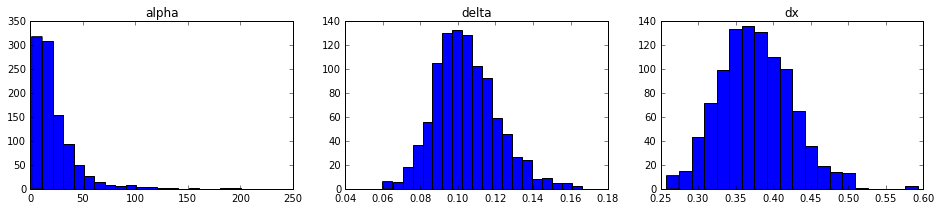

In [179]:
plt.figure(figsize=(16,3))
plt.subplot(1,3,1)
plt.hist(rslt_var_extract['alpha'], bins=20)
plt.title('alpha')
plt.subplot(1,3,2)
plt.hist(rslt_var_extract['delta'], bins=20)
plt.title('delta')
plt.subplot(1,3,3)
plt.hist(rslt_var_extract['dx'], bins=20)
plt.title('dx')

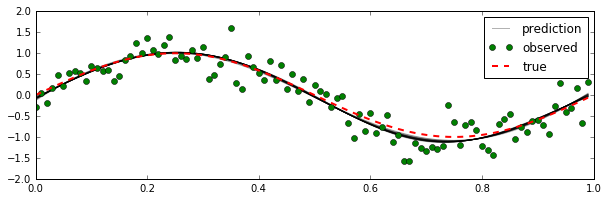

In [180]:
# drawing 20 samples for t
plt.figure(figsize=(10,3))
for i in range(0, len(rslt_var_extract['t']), 50):
    if i==0:
        plt.plot(x, rslt_var_extract['t'][i], 'k',alpha=0.3, label='prediction')
    else:
        plt.plot(x, rslt_var_extract['t'][i], 'k',alpha=0.3)
plt.plot(x, y, 'go', label='observed')
plt.plot(x, t, '--r', label='true', linewidth=2)
plt.legend()